In [1]:
import sys
sys.path.append("..")
sys.path.append("../neurontree/")

from computation import file_manager as fm
import NeuronTree as nt
import pandas as pd
import networkx as nx
import numpy as np

# Load file

In [2]:
N = fm.load_swc_file("../data/EC3-80604.CNG.swc")

There are 2-3 soma points. The location and the radius of the soma is estimated based on their mean.


# Plotting

Each NeuronTree object comes with its own plotting function `draw_2D()`. The parameter `projection` let's you choose which 2D projection to plot.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

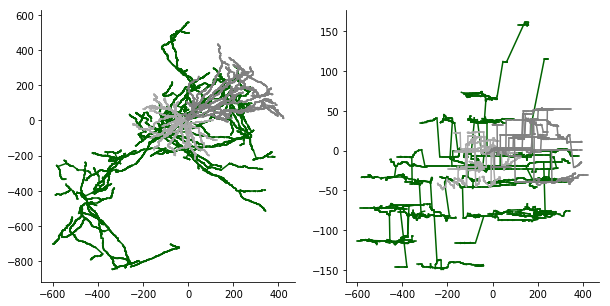

In [4]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
N.draw_2D(fig, ax=ax1, projection='xy')

ax2= plt.subplot(122)
N.draw_2D(fig, ax=ax2, projection='xz')

sns.despine()

In case you want to check out all of the three possible 2D projections at once you can also use the provided `show_threeview()`

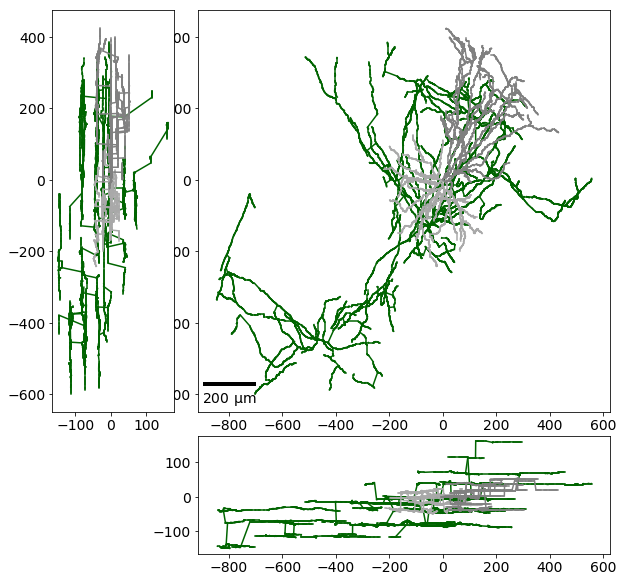

In [16]:
from neurontree.plotting import show_threeview

fig = plt.figure(figsize=(10,10))
show_threeview(N, fig)

### Plotting axon and dendrites and neurites indepedently

The above plot is a bit busy. The axon is large and entangled with the dendrites, so you might want to look at axons and dendrites independently.

In [4]:
Axon = N.get_axonal_tree()
Dendrites = N.get_dendritic_tree()

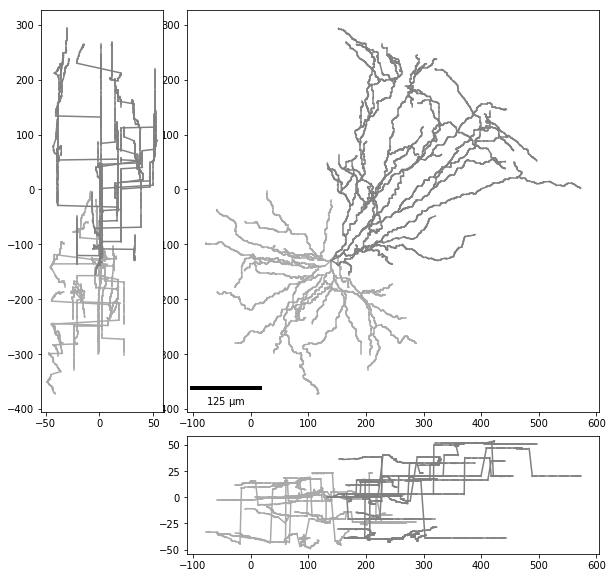

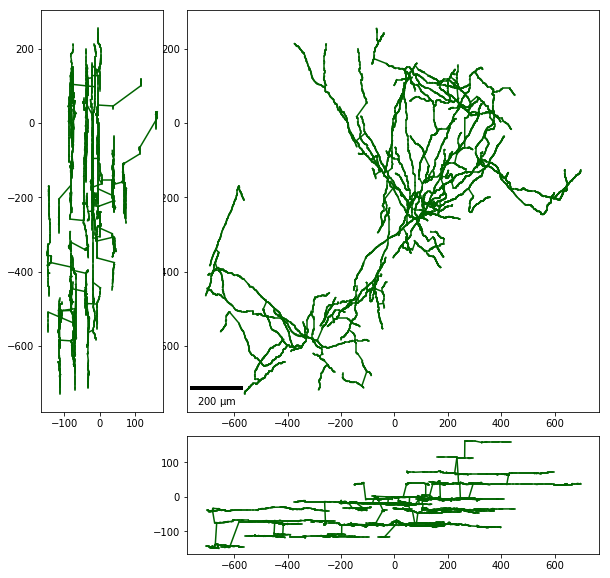

In [9]:
dendrite_fig = plt.figure(figsize=(10,10))
show_threeview(Dendrites, dendrite_fig)
plt.title('Dendrites')

axon_fig = plt.figure(figsize=(10,10))
show_threeview(Axon, axon_fig)
plt.title('Axon')

You can also look at individual neurites that extend from the soma.

In [ ]:
TODO

# Resampling and the topological minor of a reconstruction

Reconstruction files can have several thousand nodes. Sometimes it can make sense to reduce a reconstruction by e.g. resampling or different techniques. MorphoPy offers two functions for this: `resample_tree(dist)` and `get_topological_minor()`.

`resample_tree(dist)` returns a new NeuronTree where all points along a path are resampled to have the specified distance `dist`. Original branch points will be kept. If a branch is smaller than the specified distance it will get pruned away.

In [8]:
dendrite = Dendrites.get_neurites()[4] 
T5 = dendrite.resample_tree(dist=5)
T20 = dendrite.resample_tree(dist=20)

Text(0.5, 1.0, 'Sampling points at 20 microns')

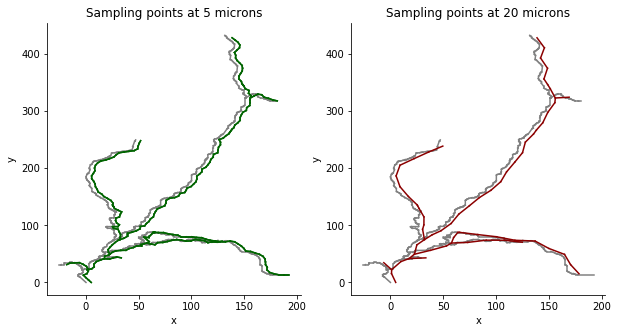

In [11]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
dendrite.draw_2D(fig,ax1, projection='xy')
T5.draw_2D(fig, ax1, projection='xy',x_offset=5, apical_dendrite_color='darkgreen')
sns.despine()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampling points at 5 microns')


# Note at this sampling resolution the tips start to get pruned away. 
ax2 = plt.subplot(122)
dendrite.draw_2D(fig,ax2, projection='xy')
T20.draw_2D(fig,ax2, projection='xy',x_offset=5, apical_dendrite_color='darkred')
sns.despine()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampling points at 20 microns')

`get_topological_minor()` reduces the reconstruction to its branch points and tips. 

Text(0.5, 0.98, 'Topological minor of the dendrites')

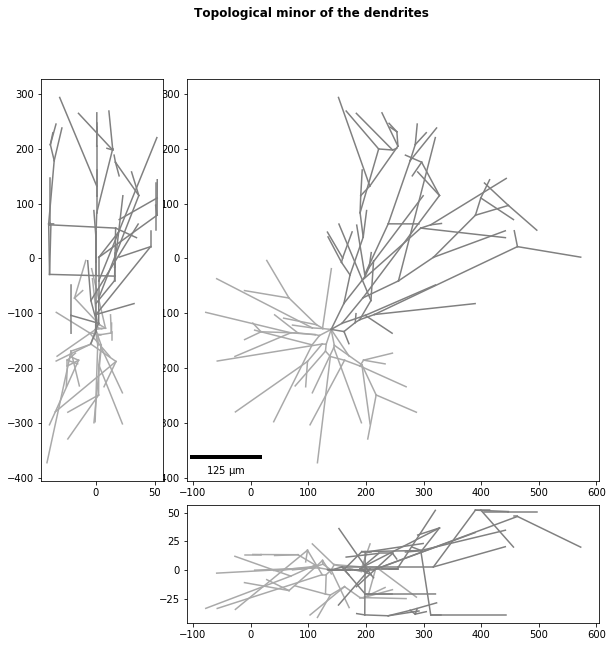

In [29]:
D = Dendrites.get_topological_minor()

fig = plt.figure(figsize=(10,10))
show_threeview(D, fig)
plt.suptitle('Topological minor of the dendrites', weight='bold')

A nice thing to note is that the original path length of a now reduced edge is kept as an edge attribute `path_length`.

In [27]:
total_length_unreduced = np.sum(list(Dendrites.get_segment_length(dist='path_length').values()))
total_length_unreduced

12014.243070272307

In [28]:
total_length_reduced = np.sum(list(D.get_segment_length(dist='path_length').values()))
total_length_reduced


12014.243070272307

# Feature representations

## Compute the Persistence Diagram

By default MorphoPy implements four different distance functions for persistence diagrams: radial distance to soma, path length to soma, height to soma, and branch order (to be found in computations.persistence_functions).


In [4]:
from computation.persistence_functions import path_length, radial_distance, height, branch_order
from computation.feature_presentation import get_persistence

In [5]:
filter_function = path_length

df = get_persistence(N.get_topological_minor(), f=filter_function) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,486.036126,470.124006,7911,4
1,522.789591,486.813012,3914,4
2,1994.378163,1908.620819,14377,2
3,850.796639,829.042101,19423,2
4,1056.351048,1049.561048,15814,2


However, one can also provide a custom distance function. It only needs to follow the form `function(networkx.DiGraph(), node_id_end, node_id_start)` and return the distance between start node and end node.

In [6]:
import numpy as np
def custom_distance(G, u, v):
    """
    Returns a distance between nodes u and v, which both are part of the graph given in G.
    """
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.dot(n, r)

In [7]:
df = get_persistence(N.get_topological_minor(), f=custom_distance) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,0.0,0.0,7911,4
1,0.0,0.0,3888,4
2,0.0,0.0,14310,2
3,0.0,0.0,19423,2
4,0.0,0.0,15881,2


## Compute Morphometric Statistics

MorphoPy offers a default selection of 28 single valued morphometric statistics.

In [6]:
from computation.feature_presentation import compute_morphometric_statistics

In [7]:
compute_morphometric_statistics(N)

,depth,log_min_tortuosity,stems,max_branch_angle,tips,median_intermediate_segment_pl,branch_points,max_thickness,log_median_tortuosity,tree_asymmetry,...,avg_thickness,height,min_path_angle,max_degree,log_max_tortuosity,max_branch_order,total_volume,mean_branch_angle,total_length,total_surface
0,1402.95,0.0,9.0,178.914616,224.0,40.04412,216.0,0.42,0.111493,0.814848,...,0.235766,310.68,0.0,2.0,0.822798,36.0,18057.476465,95.860954,32329.041344,51834.754807


However, you might want to compute only a subset of these features or something completely different. The neurontree object allows you to query several different distributions and values. Below you find a subset of the computations done in the `compute_Morphometric_Statistics()` method. For more use cases check out the documentation of the neurontree.

You feel like using the command line tool but want different statistics? No problem, just fill in your code into the `compute_Morphometric_Statistics()` method.

In [6]:
z = dict()

# number of branch points
z['branch_points'] = N.get_branchpoints().size

# x, y and z extend of the neuron: max - min
extend = N.get_extend()

z['width'] = extend[0]
z['depth'] = extend[1]
z['height'] = extend[2]

# returns all tips of the reconstruction
tips = N.get_tips()
z['tips'] = tips.size
root = N.get_root()
z['stems'] = len(N.edges(root))

z['total_length'] = np.sum(list(N.get_edge_attributes('path_length').values()))

# get all radii
radii = N.get_node_attributes('radius')
# delete the soma
radii.pop(root)

z['avg_thickness'] = np.mean(list(radii.values()))
z['max_thickness'] = np.max(list(radii.values()))

R = N.get_topological_minor()
segment_length = R.get_segment_length()
terminal_segment_pl = [item[1] for item in segment_length.items() if item[0][1] in tips]
intermediate_segment_pl = [item[1] for item in segment_length.items() if item[0][1] not in tips]

z['max_segment_path_length'] = np.max(list(segment_length.values()))
z['median_intermediate_segment_pl'] = np.median([0] + intermediate_segment_pl)
z['median_terminal_segment_pl'] = np.median(terminal_segment_pl)


branch_angles = list(R.get_branch_angles().values())
z['max_branch_angle'] = np.max(branch_angles)
z['min_branch_angle'] = np.min(branch_angles)
z['mean_branch_angle'] = np.mean(branch_angles)

# get maximal degree within data
z['max_degree'] = np.max([item[1] for item in R.get_graph().out_degree().items() if item[0] != root])

# get tree asymmetry
weights, psad = R.get_psad()
if np.sum(list(weights.values())) != 0:
    z['tree_asymmetry'] = np.sum([weights[k]*psad[k] for k in psad.keys()])/np.sum(list(weights.values()))
else:
    z['tree_asymmetry'] = 0
    
pd.DataFrame.from_dict(z, orient='index').T

,height,tips,depth,max_degree,stems,avg_thickness,max_segment_path_length,median_terminal_segment_pl,min_branch_angle,total_length,mean_branch_angle,max_thickness,median_intermediate_segment_pl,branch_points,width,tree_asymmetry,max_branch_angle
0,310.68,224.0,1402.95,2.0,9.0,0.235766,583.515986,54.73532,11.866878,32329.041344,95.860954,0.42,40.04412,216.0,1021.85,0.814848,178.914616


## Compute Density Maps

Density maps are (often lower dimensional) binned histograms over the neural mass. MorphoPy allows you to create density maps of different projections through the function `compute_denisty_maps()`.
Per default it computes x, y, z, xy and xz density maps using 20 bins per dimension and Gaussian smoothing. However you can also provide it with a `config_param` dictionary to specfiy your own processing parameters. 

In [5]:
from computation.feature_presentation import compute_density_maps, plot_density_maps

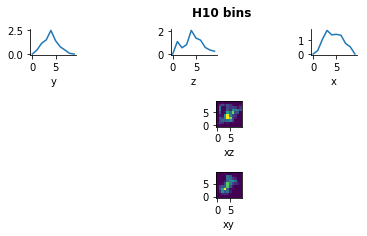

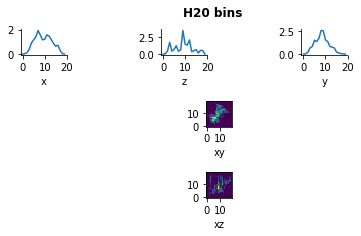

In [6]:
densities = compute_density_maps(Dendrites)

# plot all maps
plots = plot_density_maps(densities)

## Compute Morphometric Distributions

MorphoPy offers you to query a range of different morphometric distributions via the `get_histogram(key, dist_measure=None, **kwargs)` method. If no `dist_measure` is passed the distributions are typically one-dimensional.

Possible keys are:

    - branch orders
    - Strahler order
    - branch angles
    - path angles
    - root angles
    - thickness
    - segment lengths
    - path length to soma
    - radial distance

Text(0.5, 0.98, '1-D morphometric distributions')

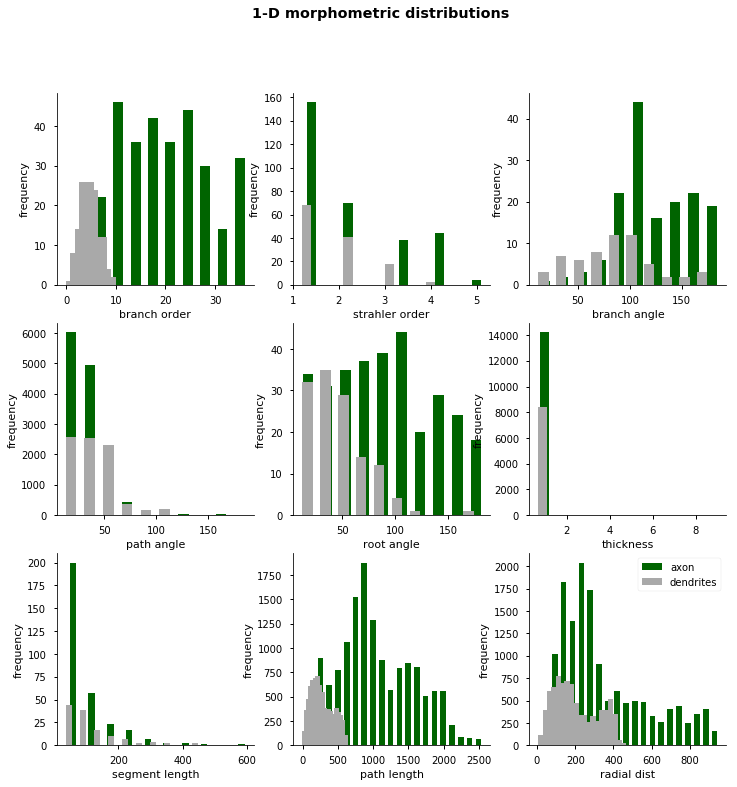

In [79]:
# show morphometric distirbutions for axon and dendrites separately. 
sns.set_context('notebook')
statistics = ['branch_order', 'strahler_order', 
              'branch_angle', 'path_angle', 'root_angle', 
              'thickness', 'segment_length', 'path_length', 'radial_dist']

hist_widths = [2,.2, 10, 10, 10, .4, 20, 80, 30]
A = Axon.get_topological_minor()
D = Dendrites.get_topological_minor()

plt.figure(figsize=(12,12))
k = 1
for stat, w in zip(statistics,hist_widths):
    plt.subplot(3,3,k)
    for Trees, c in [[(Axon, A), 'darkgreen'], [(Dendrites, D), 'darkgrey']]:
        if stat in ['branch_order', 'strahler_order', 'root_angle']:
            dist, edges = Trees[1].get_histogram(stat)
        else: 
            if stat in ['segmen_length', 'path_length', 'radial_dist']:
                bins=20
            else:
                bins=10
            dist, edges = Trees[0].get_histogram(stat, bins=bins) # you can pass options to the histogram method

        
        plt.bar(edges[1:], dist, width=w, color=c)
        sns.despine()
        plt.xlabel(stat.replace("_", " "))
        plt.ylabel('frequency')

    k+=1

plt.legend(['axon', 'dendrites'])
plt.suptitle('1-D morphometric distributions', weight='bold')


All 1D distributions can also be queried with a distance function via the parameter `dist_measure`. This is a good way to see their spatial progression with distance to the soma. The returned distribution then becomes two-dimensional.


In [7]:
dist_both, edges_both = Axon.get_histogram('branch_angle', dist_measure='radial')
dist_ba , edges_ba = Axon.get_histogram('branch_angle')
dist_r , edges_r = Axon.get_histogram('radial_dist')

Text(0, 0.5, 'radial distance')

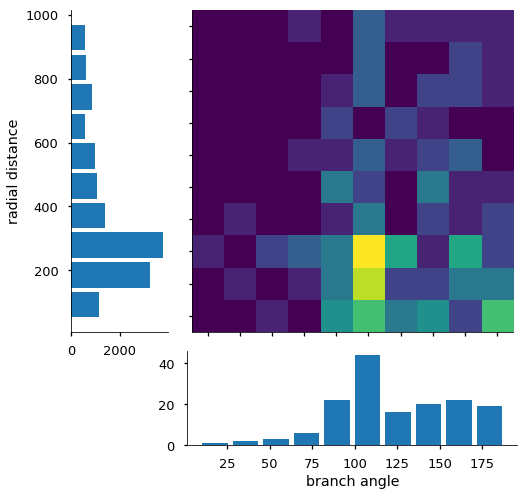

In [8]:
sns.set_context('talk')
plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(dist_both) 
ax1.set_xticks(range(len(edges_both[1])-1))
ax1.set_xticklabels('')
ax1.set_yticks(range(len(edges_both[0])-1))
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.bar(edges_ba[1:], dist_ba, width=15)
sns.despine()
ax3.set_xlabel('branch angle')

ax2.barh(edges_r[1:], dist_r, height=80)
ax2.set_ylabel('radial distance')

These distribution plots for example tell you that the axon starts branching heavily about 200-300 microns away from the soma and its branching angles tend to be large (>70).

## Gaussian kernel density estimates
The same distributions can also be queried as Gaussian kernel density estimates.

Text(0, 0.5, 'radial distance')

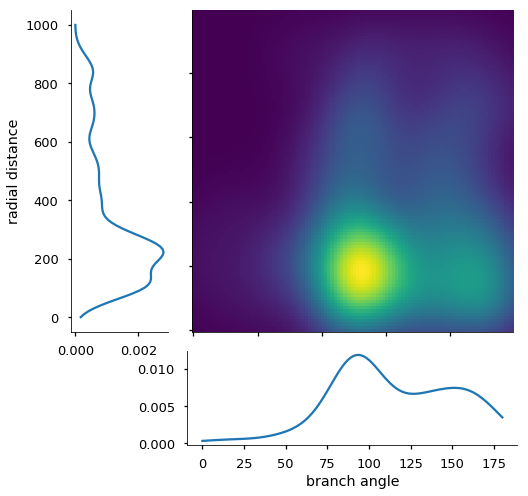

In [17]:
# Get the kernel density estimate
kde_both = Axon.get_kde_distribution('branch_angle', dist_measure='radial')
kde_ba  = Axon.get_kde_distribution('branch_angle')
kde_r = Axon.get_kde_distribution('radial_dist')

# create sampling points for plotting
x_ba = np.linspace(0,180,100)
x_r = np.linspace(0,1000,100)

r,ba = np.mgrid[0:1000:100j,0:180:100j]
sampling_positions = np.vstack([r.ravel(), ba.ravel()])
Z = np.reshape(kde_both(sampling_positions).T, r.shape)


# Plot data
sns.set_context('talk')
plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(Z) 
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.plot(x_ba, kde_ba(x_ba))
sns.despine()
ax3.set_xlabel('branch angle')

ax2.plot(kde_r(x_r), x_r)
ax2.set_ylabel('radial distance')

### Sholl intersection profiles

A special distribution not metioned yet is the Sholl intersection profile. It counts how often a 2D projection of the neural arbors intersects with concentric circles of growing radius (idea developed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1244622/)). The center is usually placed at the soma. In our implementation one can also choose to use the centroid of the arbors' convex hull as a center point.

Text(0, 0.5, '#intersections')

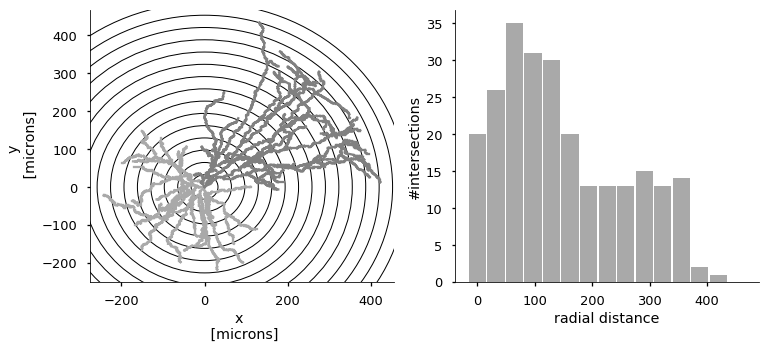

In [136]:
from matplotlib.patches import Circle

# get the sholl intersection profileof the xy projection using 15 circles and the soma as center. 
counts, radii = Dendrites.get_sholl_intersection_profile(proj='xy', steps=15, centroid='soma')

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
Dendrites.draw_2D(fig, projection='xy')
sns.despine()
ax1.set_xlabel('x \n [microns]')
ax1.set_ylabel('y \n [microns]')

for r in radii:
    
    circ = Circle((0,0),r, edgecolor='k', facecolor=None, fill=False, linewidth=1)
    ax1.add_artist(circ)
    
ax2 = plt.subplot(122)
ax2.bar(radii[:-1], counts, color='darkgrey', width=30)
sns.despine()
ax2.set_xlabel('radial distance')
ax2.set_ylabel('#intersections')